In [4]:
from transformers import BertTokenizerFast, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning import Trainer
import pandas as pd

# Importation de la bibliothèque pandas
import pandas as pd

# Lecture du fichier CSV et stockage des données dans un DataFrame
df = pd.read_csv('../dataset.csv')



# Remplacement des retours à la ligne dans la colonne 'description' par des espaces
df['description'] = df['description'].str.replace('\n', ' ')

# Sélection des colonnes 'description' et 'cat1' du DataFrame
df = df[['description', 'cat1', 'cat2', 'cat3']]

# Remplacement des retours à la ligne dans la colonne 'description' par des espaces
df['description'] = df['description'].str.replace('\n', ' ')

df['cat1'].fillna('missing', inplace=True)
df['cat2'].fillna('missing', inplace=True)
df['cat3'].fillna('missing', inplace=True)



/tmp/ipykernel_17800/2647189979.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['cat1'].fillna('missing', inplace=True)
/tmp/ipykernel_17800/2647189979.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

In [11]:
LABELS = [
          "Balade",
          "Spectacle",
          "Culture",
          "Détente",
          "Fête",
          "Gastronomie",
          "Famille",
          "Sport",
          "Festival",
          "Atelier",
          "Environnement",
          "Danse",
          "Marché",
          "Théatre",
          "Concert",
          "Exposition",
          "Jeu",
          "Visite",
          "Histoire",
          "Art",
          "Brocante",
          "Action",
          "Santé",
          "Conférence"
          ]

df_new = df.copy()
for label in LABELS:
  df_new.insert(df_new.shape[1], label, pd.Series(0, dtype=int, index=range(df_new.shape[0])))

for row in df_new.iterrows():
  for cat in ['cat1', 'cat2', 'cat3']:
    for cat_col in LABELS:
      if row[1].loc[cat] == cat_col:
        df_new.at[row[0], cat_col] = 1
        break

df_new.drop(columns=['cat1', 'cat2', 'cat3'], inplace=True)
df_new = df_new.iloc[:, :]

df_new.head()

#convertir df en csv

df_new.to_csv('dataset2.csv', index=False)



In [8]:
for column in df_new.columns:
    print(df_new[column].value_counts())

description
Pauline d'UP & Go, coach en développement personnel et bien-être vous accompagnera durant un atelier/coaching de 3h centré sur votre équilibre émotionnel, physique et environnemental. Grâce à son expérience personnelle et ses compétences d’Ingénieure Pédagogique, elle vous guidera tout en douceur à travers cet atelier collectif."Le but est de bâtir avec le potentiel du collectif.Partager ensemble nos réflexions, nos expériences et vous donner des clés qui pourraient changer vos vies et retrouver un équilibre au quotidien."                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

/home/utilisateur/Documents/dev_ia/fine-tune-classification/farid/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 11825 (\N{WORD SEPARATOR MIDDLE DOT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/utilisateur/Documents/dev_ia/fine-tune-classification/farid/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/utilisateur/Documents/dev_ia/fine-tune-classification/farid/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127795 (\N{DECIDUOUS TREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/utilisateur/Documents/dev_ia/fine-tune-classification/farid/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, 

ValueError: Image size of 563x152521 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x480 with 1 Axes>

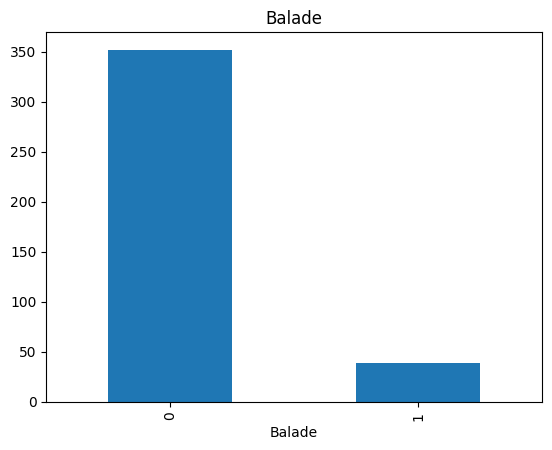

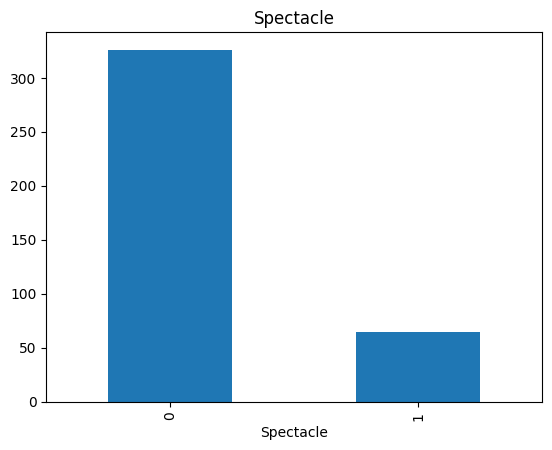

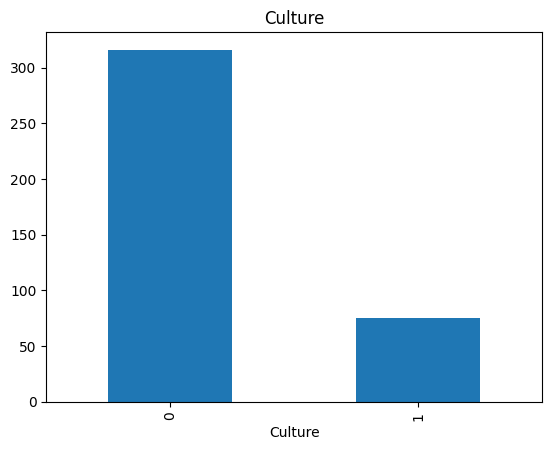

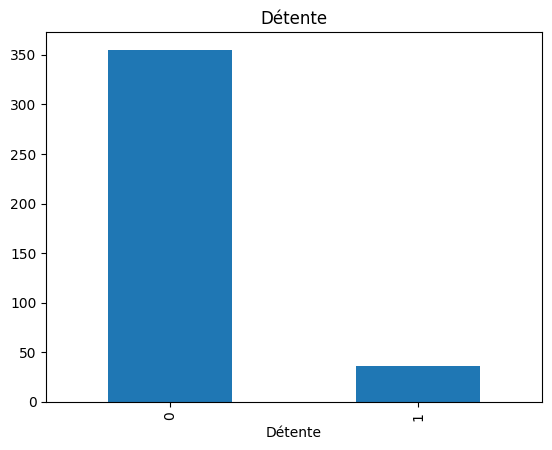

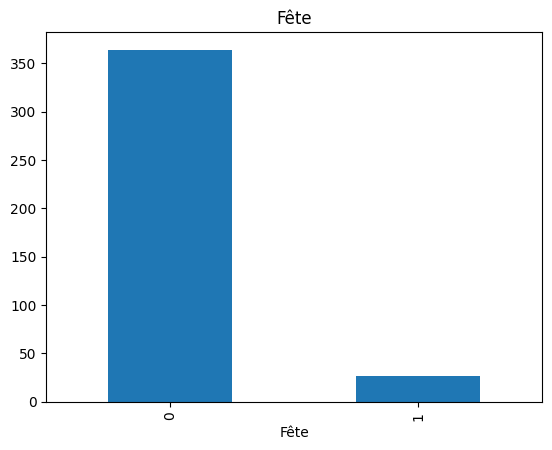

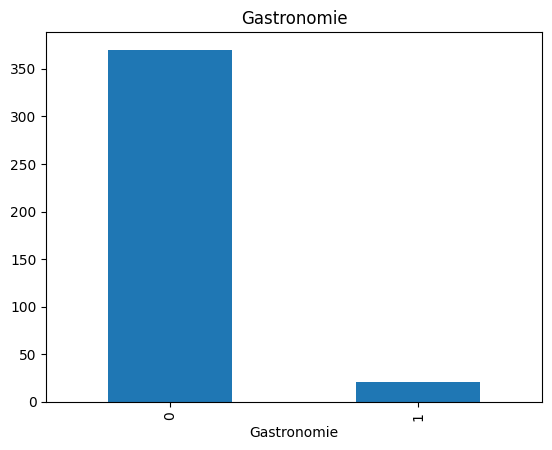

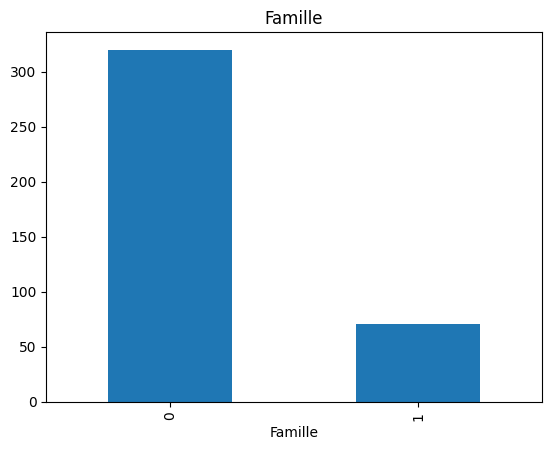

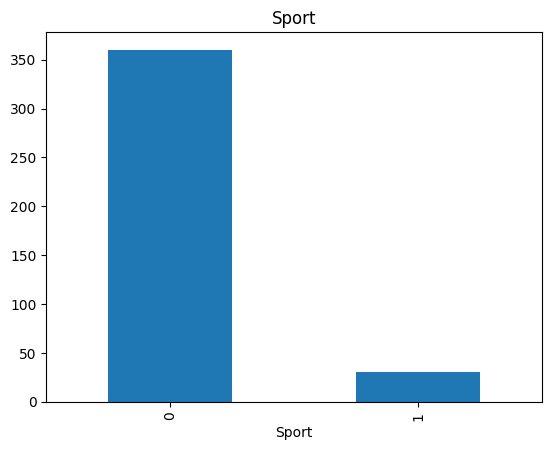

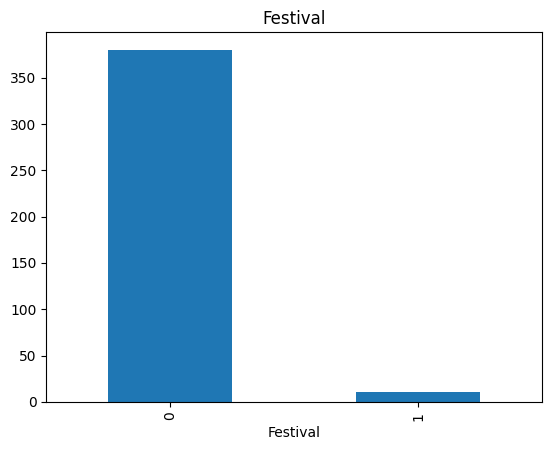

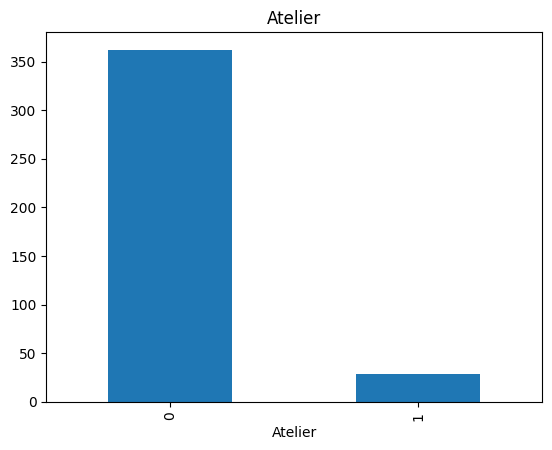

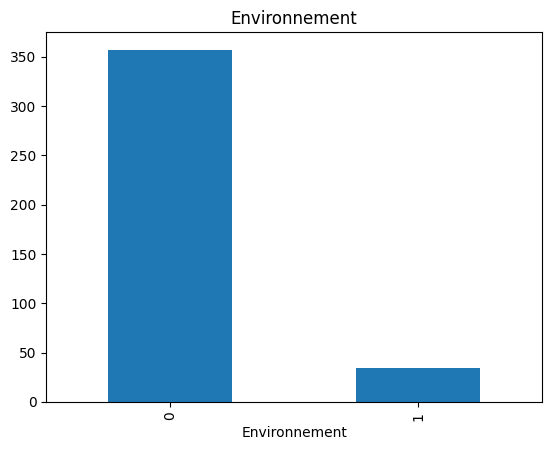

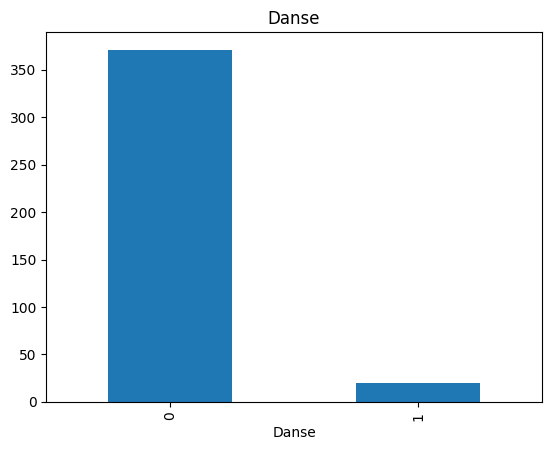

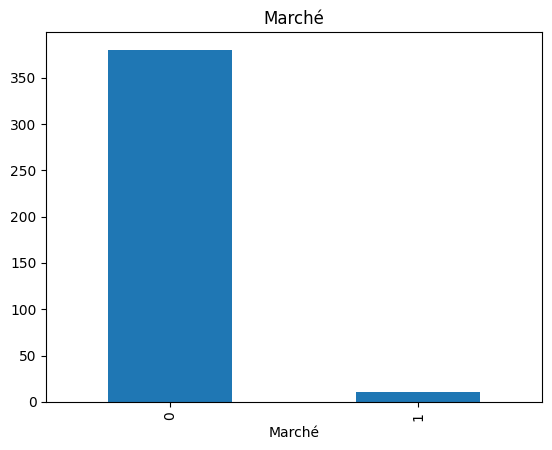

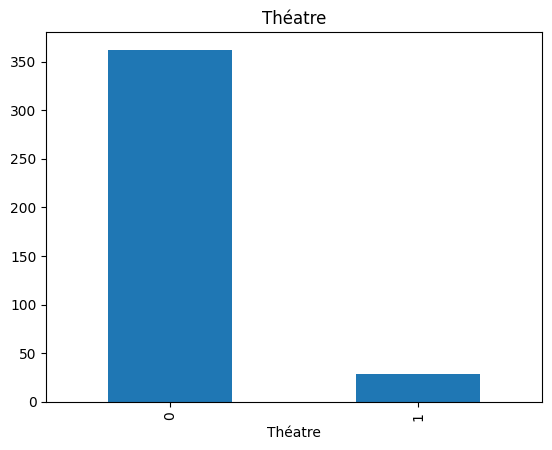

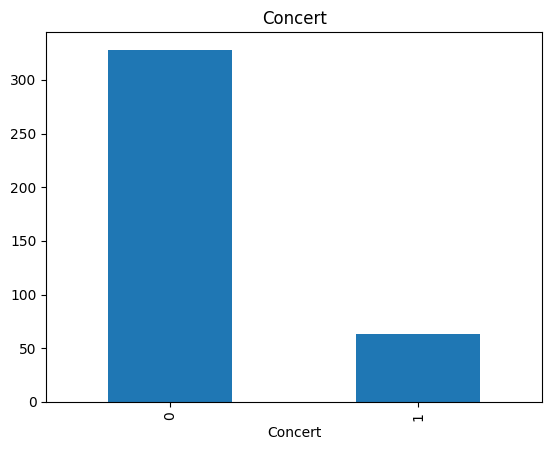

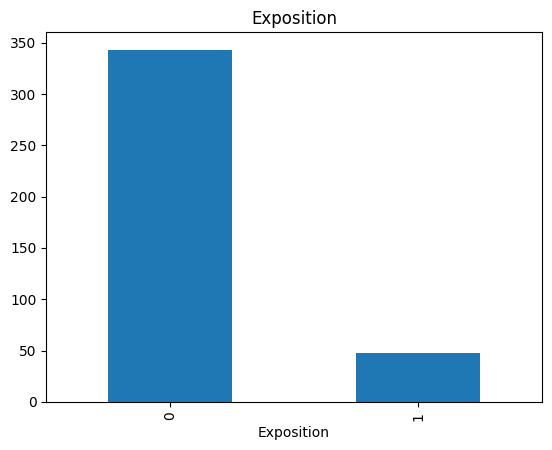

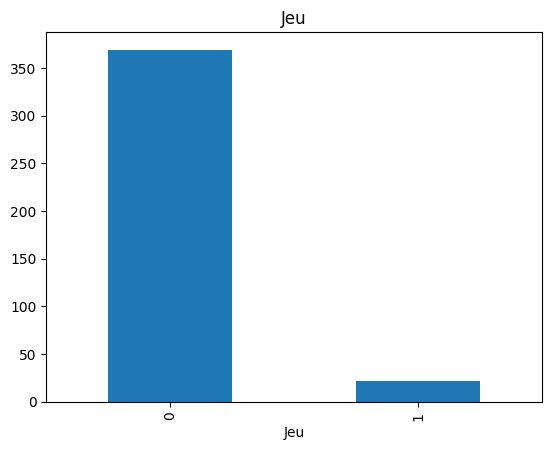

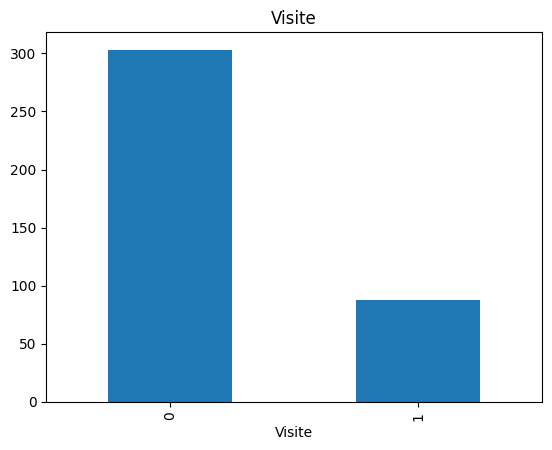

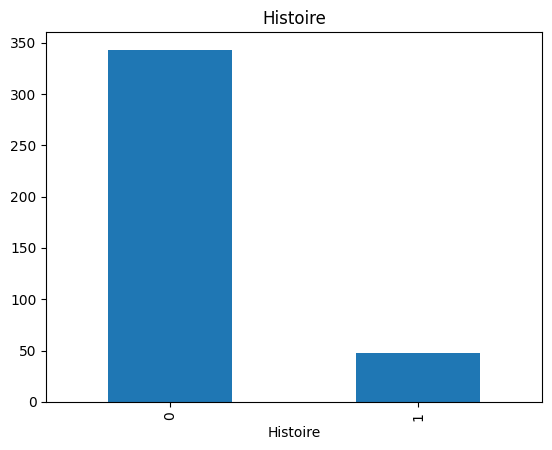

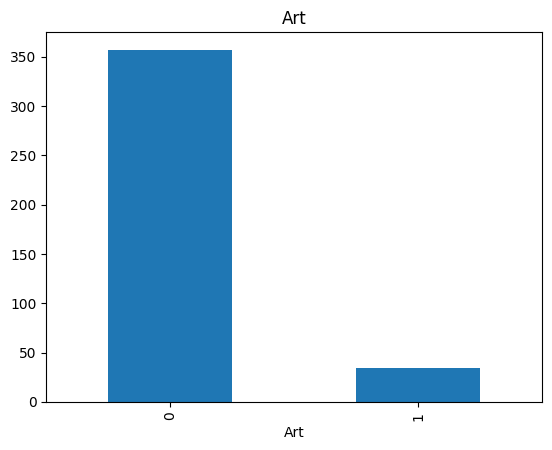

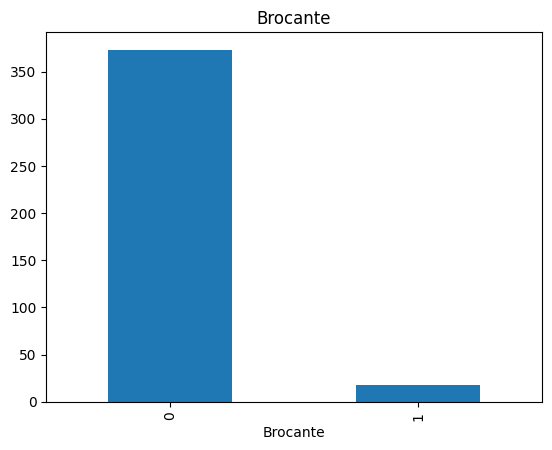

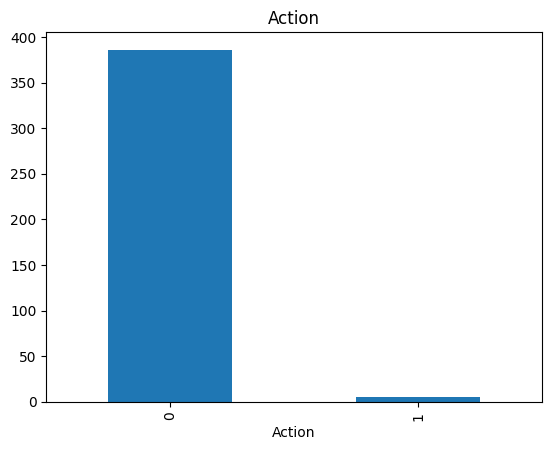

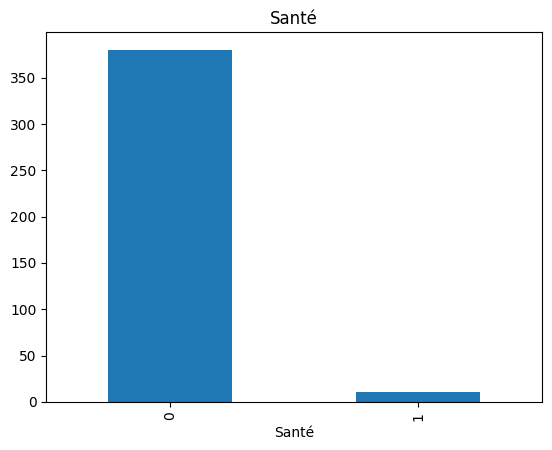

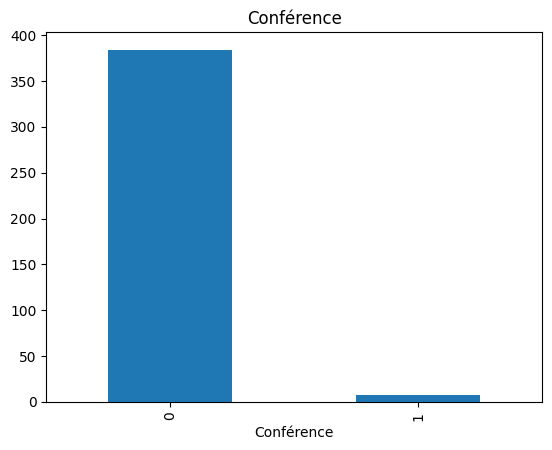

In [10]:
import matplotlib.pyplot as plt

for column in df_new.columns:
    df_new[column].value_counts().plot(kind='bar')
    plt.title(column)
    plt.show()